# What is a Recurrent Neural Network?

A recurrent layer is just a memory cell that computes. In diagrams, you may see it represented as having many cells, but it is just one cell used to calculate an output over a set amount of time steps. The cell calculates Y_0 at X_0 then moves on to calculating Y_1 at X_1 and so on. However, from X_0 to X_1 the memory cell produces a state vector. This state factor is used in the next time step as an additional input factor. This state factor is why it is called a recurrent neural network. Just as x +=1 is a recurrent function to add 1 every time to X, every time step receives an state vector from the last time step.

This architecture enables you to use any sequence length as long as the parameters remain constant. An RNN can be though of as word context of reading a sentence. As you read the a sentence you may only be focusing on one word, however, if you encounter a word that is a homphone such as lead you will understand the context. You can immediate notice if lead is the verb for "guiding" or the soft metal which is a noun.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
  
  
def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [3]:
# Read in data
spy = pd.read_csv('SPY.csv')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 6949


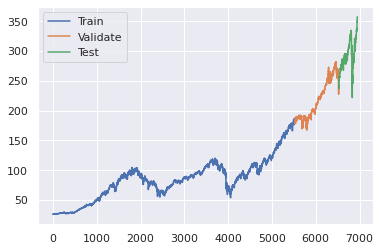

In [4]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [5]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

## Simple RNN Forecasting

The input for the memory cell at each time step is the batch size by our feature dimensionality (1). The output is thiese same two dimensions times the number of units in the memory cell. Our memory cell is comprised of 100 units in both layers. So the output of our RNN layer is batch(128), window_size(30), and number of units (100) which is obviously 3 dimensional. The output Y_0 is the state vector which is used when calculating Y_1 at the next time step. 

In this instance we are doing sequence to vector which means we ignore all outputs except for the one at the very last time step. This is the default behavior of all reccurent layers in Keras unless return_sequences = True is selected. This sequence to vector takes in a batch (128) of time windows and outputs the next time step of window of values. This one at a time output proves to be very slow when training.

For a faster training convergence, we use a sequence to sequence RNN. Compared to the sequence to vector which adjusted the gradient of the loss from the very end of the model all the at layer 2 unit 100, the sequence to sequence RNN calculates the loss at each time step and backpropagates the loss from there. This provides much more gradients and speeds up training. It is important to note we still ignore all outputs besides the last one. We just calculate all intermediate values to update the gradient more quickly.

3

In [ ]:
# Clear any back end stored data due to multiple iterations
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size
window_size = 30

# Create 2D batches of batch size and features (1 feature = 1 time step in window)
train_set = window_dataset(normalized_x_train, window_size, batch_size=128)

# Establish Model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Add a 3rd dimension (feature dimensionality which in this case in univariate)
                      input_shape=[None]), # 1st dimension is batch size, input shape = None allows windows of any size to be used
  keras.layers.SimpleRNN(100, return_sequences=True), # takes in sequence (batch size, time, dimensionality per time step (univariate))
  keras.layers.SimpleRNN(100), # produces a single vector
  keras.layers.Dense(1), # produces 1 output 
])

# create standard learning rate scheduler
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

# establish optimizer
optimizer = keras.optimizers.Nadam(lr=1e-7)

# Put model all together
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, .1])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(normalized_x_train, window_size, batch_size=128)
valid_set = window_dataset(normalized_x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
])
optimizer = keras.optimizers.Nadam(lr=5e-5)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Set early stopping to prevent over fitting
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# save best model to load later
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# compile model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

In [ ]:
model = keras.models.load_model("my_checkpoint")

In [ ]:
rnn_forecast = model_forecast(
    model,
    spy_normalized_to_traindata[x_test.index.min() - window_size:-1],
    window_size)[:, 0]

In [ ]:
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(422,)

In [ ]:
plt.figure(figsize=(10,6))

plt.title('SeqtoVec RNN Forecast')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plot_series(x_test.index, x_test)
plot_series(x_test.index, rnn_unscaled_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

## Sequence-to-Sequence Forecasting

In [ ]:
def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

The cell below illustrates exactly what the function above is doing. the cell above creates batches and laebls for those batches. The point Y[0] is the label for X[0] to try to calculate.

In [2]:
# Show example of what seq-seq looks like
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3, batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

NameError: ignored

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

# in the seq2seq_window we removed the need for the lambda layer to expand dimensions as it is already 3D 
train_set = seq2seq_window_dataset(normalized_x_train.flatten(), window_size,
                                   batch_size=128)

# Create model
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1), # now dense layer is applied at every time step
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 30))

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# create history callback from fit
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, .1])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequences
window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train.flatten(), window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid.flatten(), window_size,
                                   batch_size=128)

# Create model for seq:seq RNN
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
])

# choose optimizer and LR
optimizer = keras.optimizers.Nadam(lr=1e-3)

# set model params
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=20)

# set model checkpoint to save best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

In [ ]:
# recall best model
model = keras.models.load_model("my_checkpoint")

In [ ]:
# create forecast and clip to only show test values
rnn_forecast = model_forecast(model, spy_normalized_to_traindata.flatten()[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[x_test.index.min() - window_size:-1, -1, 0]

In [ ]:
# Get data back to normal scale
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(422,)

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.title('SeqtoSeq RNN')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plot_series(x_test.index, x_test)
plot_series(x_test.index, rnn_unscaled_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()